In [15]:
import pandas as pd

articles = pd.read_csv('../process_articles/validated_articles.csv')
articles.head(1)

,authors,title,date,year,edition,url,text,quarter,year_quarter
0,NaN,本期导读,2023-01-01,2023,1.0,http://www.qstheory.cn/dukan/qs/2023-01/01/c_1...,本期发表了习近平总书记的重要讲话《为实现党的二十大确定的目标任务而团结奋斗》。讲话强调，全面...,1,2023 Q1


## Check out the length of the articles - I think some models have token limits

In [16]:
articles['text_length'] = articles['text'].apply(lambda x: len(x))

In [17]:
articles['text_length'].describe()

count     1998.000000
mean      4651.866867
std       3015.892857
min        237.000000
25%       1815.750000
50%       5047.500000
75%       6742.250000
max      32678.000000
Name: text_length, dtype: float64

<Axes: xlabel='text_length', ylabel='Count'>

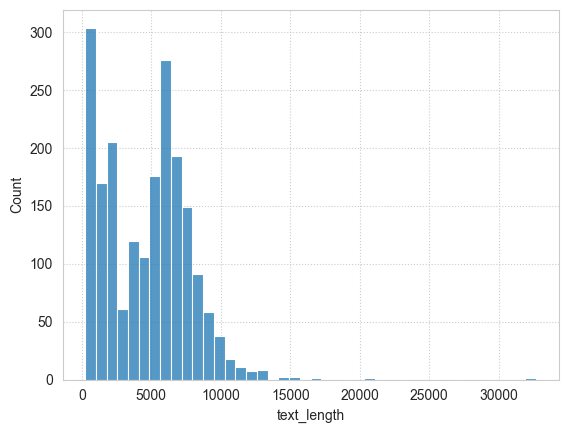

In [29]:
import seaborn as sns

sns.set_style("whitegrid", {'grid.linestyle': ':'})

sns.histplot(data=articles, x='text_length')

<Axes: xlabel='text_length'>

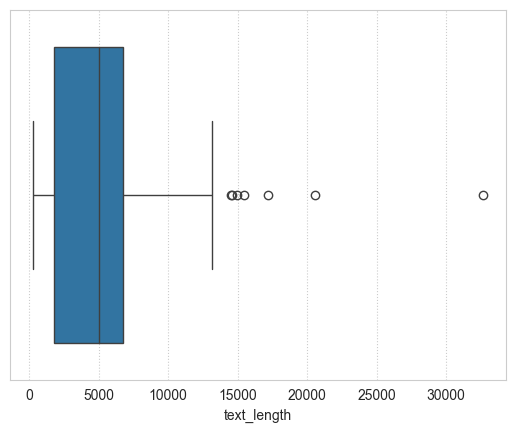

In [30]:
sns.boxplot(data=articles, x='text_length')

In [33]:
long_articles = articles[articles['text_length'] >= 15000]
len(long_articles)

4

In [20]:
long_articles

,authors,title,date,year,edition,url,text,quarter,year_quarter,text_length
819,['习近平'],高举中国特色社会主义伟大旗帜 为全面建设社会主义现代化国家而团结奋斗,2022-11-01,2022,21.0,http://www.qstheory.cn/dukan/qs/2022-11/01/c_1...,高举中国特色社会主义伟大旗帜为全面建设社会主义现代化国家而团结奋斗——在中国共产党第二十次全...,4,2022 Q4,32678
820,NaN,十九届中央纪律检查委员会向中国共产党第二十次全国代表大会的工作报告,2022-11-01,2022,21.0,http://www.qstheory.cn/dukan/qs/2022-11/01/c_1...,十九届中央纪律检查委员会向中国共产党第二十次全国代表大会的工作报告（2022年10月22日中...,4,2022 Q4,17211
821,NaN,中国共产党章程,2022-11-01,2022,21.0,http://www.qstheory.cn/dukan/qs/2022-11/01/c_1...,中国共产党章程（中国共产党第二十次全国代表大会部分修改，2022年10月22日通过）总 纲中...,4,2022 Q4,20540
1032,['《求是》杂志编辑部'],红色江山永不变色,2021-05-15,2021,10.0,http://www.qstheory.cn/dukan/qs/2021-05/15/c_1...,红色江山永不变色《求是》杂志编辑部“新中国是无数革命先烈用鲜血和生命铸就的。要深刻认识红色政...,2,2021 Q2,15459


In [34]:
list(long_articles['url'])

['http://www.qstheory.cn/dukan/qs/2022-11/01/c_1129089160.htm',
 'http://www.qstheory.cn/dukan/qs/2022-11/01/c_1129089158.htm',
 'http://www.qstheory.cn/dukan/qs/2022-11/01/c_1129089139.htm',
 'http://www.qstheory.cn/dukan/qs/2021-05/15/c_1127446921.htm']

## Convert all the articles to a BOW representation using Gensim

In [111]:
# load the data
articles = pd.read_csv('../process_articles/processed_articles.csv')
len(articles)

1998

In [112]:
articles = articles.sample(10)
len(articles)

10

In [113]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


In [114]:
# import a list of Chinese stopwords, and remove them from the text
from stopwordsiso import stopwords

stopwords_zh = stopwords(["zh"])

def remove_stopwords(row_text):
    return [word for word in row_text.split(" ") if word not in stopwords_zh]

articles['cleaned_text_wspaces'] = articles['cleaned_text_wspaces'].apply(lambda row_text: remove_stopwords(row_text))

docs = list(articles['cleaned_text_wspaces'])

In [115]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)


2024-03-10 01:22:58,152 : INFO : collecting all words and their counts
2024-03-10 01:22:58,153 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2024-03-10 01:22:58,160 : INFO : collected 19765 token types (unigram + bigrams) from a corpus of 18777 words and 10 sentences
2024-03-10 01:22:58,160 : INFO : merged Phrases<19765 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2024-03-10 01:22:58,161 : DEBUG : starting a new internal lifecycle event log for Phrases
2024-03-10 01:22:58,161 : INFO : Phrases lifecycle event {'msg': 'built Phrases<19765 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2024-03-10T01:22:58.161052', 'gensim': '4.3.2', 'python': '3.11.6 (main, Nov  2 2023, 04:39:43) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.0-arm64-arm-64bit', 'event': 'created'}


In [116]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=1, no_above=0.5)

2024-03-10 01:22:58,176 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-03-10 01:22:58,183 : INFO : built Dictionary<5177 unique tokens: ['100', '1840', '200', '2016', '2019']...> from 10 documents (total 19368 corpus positions)
2024-03-10 01:22:58,183 : DEBUG : starting a new internal lifecycle event log for Dictionary
2024-03-10 01:22:58,183 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<5177 unique tokens: ['100', '1840', '200', '2016', '2019']...> from 10 documents (total 19368 corpus positions)", 'datetime': '2024-03-10T01:22:58.183512', 'gensim': '4.3.2', 'python': '3.11.6 (main, Nov  2 2023, 04:39:43) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.0-arm64-arm-64bit', 'event': 'created'}
2024-03-10 01:22:58,185 : INFO : discarding 166 tokens: [('不断', 7), ('不能', 7), ('世界', 9), ('两个', 8), ('中华民族', 6), ('中国', 9), ('中国_特色', 9), ('中央', 6), ('中心', 8), ('事业', 6)]...
2024-03-10 01:22:58,185 : INFO : keeping 5011 tokens which were in no le

In [117]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [118]:
from gensim.models import TfidfModel
from gensim import similarities

# Step 3: Apply TF-IDF Transformation
tfidf_model = TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf_model[corpus]

# Step 4: Create MatrixSimilarity object
index = similarities.MatrixSimilarity(corpus_tfidf)

# Step 5: Compute Cosine Similarity
sims = index[corpus_tfidf]

2024-03-10 01:23:04,825 : INFO : collecting document frequencies
2024-03-10 01:23:04,826 : INFO : PROGRESS: processing document #0
2024-03-10 01:23:04,833 : DEBUG : starting a new internal lifecycle event log for TfidfModel
2024-03-10 01:23:04,833 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 10 documents and 5011 features (7208 matrix non-zeros)', 'datetime': '2024-03-10T01:23:04.833559', 'gensim': '4.3.2', 'python': '3.11.6 (main, Nov  2 2023, 04:39:43) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.0-arm64-arm-64bit', 'event': 'initialize'}
2024-03-10 01:23:04,834 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2024-03-10 01:23:04,839 : INFO : creating matrix with 10 documents and 5011 features
2024-03-10 01:23:04,840 : DEBUG : PROGRESS: at document #0/10


In [121]:
sims

array([[1.0000002 , 0.00606322, 0.01334187, 0.00825671, 0.01479065,
        0.01839012, 0.02229814, 0.0508002 , 0.03954948, 0.03679856],
       [0.00606322, 1.0000018 , 0.05456204, 0.010039  , 0.01931254,
        0.0281742 , 0.00191691, 0.02189019, 0.10029155, 0.01371736],
       [0.01334187, 0.05456204, 1.0000001 , 0.01282916, 0.03591154,
        0.01282452, 0.00448606, 0.01665564, 0.07405786, 0.02283693],
       [0.00825671, 0.010039  , 0.01282916, 0.99999833, 0.00842775,
        0.01095668, 0.00973826, 0.00975584, 0.01692184, 0.01358104],
       [0.01479065, 0.01931254, 0.03591154, 0.00842775, 1.0000012 ,
        0.00964677, 0.00672435, 0.02581234, 0.03706054, 0.02905047],
       [0.01839012, 0.0281742 , 0.01282452, 0.01095668, 0.00964677,
        1.0000019 , 0.02741647, 0.03878177, 0.04997266, 0.0396183 ],
       [0.02229814, 0.00191691, 0.00448606, 0.00973826, 0.00672435,
        0.02741647, 0.9999999 , 0.04268081, 0.0140964 , 0.08170153],
       [0.0508002 , 0.02189019, 0.0166556

In [135]:
def determine_older_article(a, b):
    """Takes two rows, and returns them and an indicator of if they are from the same
    year/edition in the order [older, newer, same_edition]"""

    # print("in determine_older_article")
    # print(f"a['year']: {a['year']}")
    # print(f"b['year']: {b['year']}")

    if (a['year']) > (b['year']):
        return b, a, False
    elif (a['year']) < (b['year']):
        return a, b, False
    # years are the same
    elif a['edition'] > b['edition']:
        return b, a, False
    elif a['edition'] < b['edition']:
        return a, b, False
    # if they are from the same edition, there isn't an older to influence a 
    # newer, so return an indicator
    else: 
        return None, None, True

In [136]:
# create a df to store the edge connections in...

df_edges_weighted = pd.DataFrame(columns=['source', 'target', 'weight', 'source_date', 'target_date', 'source_title', 'target_title'])

simplified_articles = articles.drop(columns=[column for column in articles.columns if column not in ['date', 'title', 'year', 'edition']])

for i in range(len(sims)):
    # do the lower triange in the symmetric nxn matrix
    for j in range(i+1):
        # print(f"\ni: {i}")
        # print(f"j: {j}")
        # print(f'Index i article: {simplified_articles.iloc[i]}')
        # print(f'Index j article: {simplified_articles.iloc[j]}')
        older, newer, same_edition = determine_older_article(simplified_articles.iloc[i], simplified_articles.iloc[j])

        if same_edition:
            continue

        # print('\nmade it\n')
        # print(f"Older article: {older}")
        # print(f"Newer article: {newer}")
        
        # in this case, I think the older one would be the target that the newer one 
        # is pointing back towards
        df_edges_weighted.loc[len(df_edges_weighted)] = [newer.name, older.name, sims[i][j], newer.date, older.date, newer.title, older.title]

        
        

In [148]:
simplified_articles

,title,date,year,edition
1814,科技创新是高质量发展的强大动能,2019-07-01,2019,13.0
73,塔元庄的“全家福”,2023-02-16,2023,4.0
1170,坚持在发展中保障和改善民生,2021-10-01,2021,19.0
1972,坚定不移破除形式主义、官僚主义,2019-12-01,2019,23.0
638,锚定“一本三基四梁八柱”战略框架 加快建设中国特色自由贸易港,2022-06-01,2022,11.0
704,在庆祝中国人民解放军建军90周年大会上的讲话,2022-07-31,2022,15.0
1742,把握好中国特色社会主义最本质特征和社会主义本质的关系,2019-04-16,2019,8.0
4,《求是》社论：用新的伟大奋斗创造新的历史伟业,2022-12-31,2023,1.0
550,做好新发展阶段“三农”工作的行动纲领,2022-03-31,2022,7.0
760,中国特色社会主义的形成和发展,2022-09-16,2022,18.0


In [147]:
df_edges_weighted.head(2)

,source,target,weight,source_date,target_date,source_title,target_title
0,73,1814,0.006063,2023-02-16,2019-07-01,塔元庄的“全家福”,科技创新是高质量发展的强大动能
1,1170,1814,0.013342,2021-10-01,2019-07-01,坚持在发展中保障和改善民生,科技创新是高质量发展的强大动能


In [139]:
import networkx as nx

# Create a graph from the edge list with weights
G = nx.from_pandas_edgelist(df_edges_weighted, 'source', 'target', edge_attr='weight', create_using=nx.DiGraph)

2024-03-10 01:37:33,430 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-03-10 01:37:33,431 : DEBUG : findfont: score(FontEntry(fname='/Users/calebharding/Documents/BYU/2023-2024/China_Project/qiushi_venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/NotoSansSC-ExtraLight.ttf', name='Noto Sans SC', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.1925
2024-03-10 01:37:33,431 : DEBUG : findfont: score(FontEntry(fname='/Users/calebharding/Documents/BYU/2023-2024/China_Project/qiushi_venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-03-10 01:37:33,431 : DEBUG : findfont: score(FontEntry(fname='/Users/calebharding/Documents/BYU/2023-2024/China_Project/qiushi_venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/

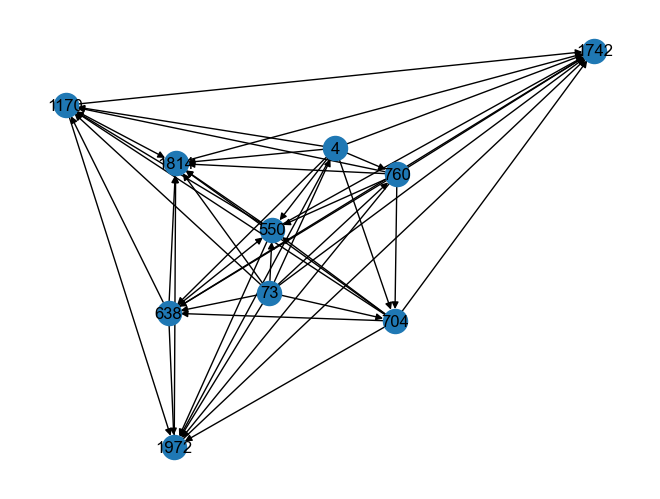

In [141]:
import matplotlib.pyplot as plt

nx.draw(G, with_labels=True)
plt.show()

In [146]:
pagerank_scores = nx.pagerank(G)

pagerank_scores = {k: v for k, v in sorted(pagerank_scores.items(), key=lambda item: item[1], reverse=True)}

print("PageRank scores:")
for node, score in pagerank_scores.items():
    print(f"Node {node}: {score}")

PageRank scores:
Node 1742: 0.28074131368393973
Node 1814: 0.16741916004521415
Node 1170: 0.11354396272801583
Node 1972: 0.10091438445380839
Node 550: 0.09681210178179604
Node 760: 0.05480045577415467
Node 704: 0.05302126768136314
Node 638: 0.05219657300735141
Node 4: 0.04168790491613626
Node 73: 0.03886287592822055


In [71]:
# the final step in creating the graph:

import pandas as pd
import networkx as nx

# Sample DataFrame representing edges with weights
df_edges_weighted = pd.DataFrame({
    'source': [1, 2, 3],
    'target': [2, 3, 4],
    'weight': [0.5, 0.8, 0.6]
})


In [80]:
row = df_edges_weighted.iloc[1]
row.source

2.0

In [ ]:

# Create a graph from the edge list with weights
G = nx.from_pandas_edgelist(df_edges_weighted, 'source', 'target', edge_attr='weight', create_using=nx.DiGraph)